In [2047]:
#Importing the required libraries from qiskit
import numpy as np
from typing import List, Callable
from scipy.optimize import minimize
from scipy.optimize._optimize import OptimizeResult
import matplotlib.pyplot as plt
from qiskit import quantum_info as qi
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, Operator, SparsePauliOp
from qiskit.primitives import StatevectorSampler, PrimitiveJob
from qiskit.circuit.library import TwoLocal
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_histogram
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke
from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator
from qiskit_aer import AerSimulator
import math
import scipy

# Defining our Hamiltonian

In [2048]:
#defining the hamiltonian of our problem by writing it as a decomposition of pauli-spin matrices
g=-1
pauli_op = SparsePauliOp(['ZZI','IZZ',"XII","IXI","IIX"],coeffs = [-1,-1,g,g,g])
#pauli_op = SparsePauliOp(['IIZ','IZI','ZII'])
print("The matrix of the hamiltonian we have defined:")

H=pauli_op.to_matrix()
print(H)


The matrix of the hamiltonian we have defined:
[[-2.+0.j -1.+0.j -1.+0.j  0.+0.j -1.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [-1.+0.j  0.+0.j  0.+0.j -1.+0.j  0.+0.j -1.+0.j  0.+0.j  0.+0.j]
 [-1.+0.j  0.+0.j  2.+0.j -1.+0.j  0.+0.j  0.+0.j -1.+0.j  0.+0.j]
 [ 0.+0.j -1.+0.j -1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j -1.+0.j]
 [-1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j -1.+0.j -1.+0.j  0.+0.j]
 [ 0.+0.j -1.+0.j  0.+0.j  0.+0.j -1.+0.j  2.+0.j  0.+0.j -1.+0.j]
 [ 0.+0.j  0.+0.j -1.+0.j  0.+0.j -1.+0.j  0.+0.j  0.+0.j -1.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j -1.+0.j  0.+0.j -1.+0.j -1.+0.j -2.+0.j]]


# Defining our initial state 

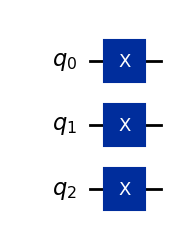

In [2049]:
#Let us define our initial state of the vector as a quantum circuit (can be done directly also)
qc=QuantumCircuit(3)
qc.x(0)
qc.x(1)
qc.x(2)

qc.draw("mpl")

In [2050]:
v=qi.Statevector(qc)
print("THE INITIAL STATE VECTOR BEFORE TIME-EVOLUTION:\n")
v=np.array(v)
print(v)

THE INITIAL STATE VECTOR BEFORE TIME-EVOLUTION:

[0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j]


# Creating a basis by repeated apllication of our Hamiltonian

In [2051]:
b=[]
b.append(v)
for i in range(1,100):
    H_i=np.linalg.matrix_power(H, i)
    v_i=np.matmul(H_i,v)
    b.append(v_i)

for i in b:
    print(i)
    print("\n")

print(len(b))    

[0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j]


[ 0.+0.j  0.+0.j  0.+0.j -1.+0.j  0.+0.j -1.+0.j -1.+0.j -2.+0.j]


[0.+0.j 2.+0.j 2.+0.j 2.+0.j 2.+0.j 0.+0.j 2.+0.j 7.+0.j]


[ -6.+0.j  -2.+0.j   0.+0.j -11.+0.j  -2.+0.j -11.+0.j -11.+0.j -18.+0.j]


[16.+0.j 28.+0.j 28.+0.j 20.+0.j 28.+0.j  0.+0.j 20.+0.j 69.+0.j]


[-116.+0.j  -36.+0.j    0.+0.j -125.+0.j  -36.+0.j -125.+0.j -125.+0.j
 -178.+0.j]


[304.+0.j 366.+0.j 366.+0.j 214.+0.j 366.+0.j   0.+0.j 214.+0.j 731.+0.j]


[-1706.+0.j  -518.+0.j     0.+0.j -1463.+0.j  -518.+0.j -1463.+0.j
 -1463.+0.j -1890.+0.j]


[4448.+0.j 4632.+0.j 4632.+0.j 2408.+0.j 4632.+0.j    0.+0.j 2408.+0.j
 8169.+0.j]


[-22792.+0.j  -6856.+0.j      0.+0.j -17433.+0.j  -6856.+0.j -17433.+0.j
 -17433.+0.j -21154.+0.j]


[59296.+0.j 57658.+0.j 57658.+0.j 28010.+0.j 57658.+0.j     0.+0.j
 28010.+0.j 94607.+0.j]


[-291566.+0.j  -87306.+0.j       0.+0.j -209923.+0.j  -87306.+0.j
 -209923.+0.j -209923.+0.j -245234.+0.j]


[ 757744.+0.j  711412.+0.j

b=[]
b.append(list(v))#appending the H^0(v) to the b list containing all the basis vectors 
for i in range(1,12):
    k=v.evolve(pauli_op**i)  #repeated application of the hamiltonian (.evolve essentially  multiplies the vector v "i" no of times)
    b.append(list(k))#appending the generated basis vector to the basis vectors list
print("The non-orthogonal basis:")
for i in b:
    print(i)
    print("\n")
print("The length of the basis",len(b))    

Defining the function which generates an orthogonal basis from  the basis we genreted above using the GRAM-SCHMID process

In [2052]:
def gram_schmidt(basis):
    
    def projection(u, v):
        return np.dot(u, v) / np.dot(u, u) * u
    
    basis = np.array(basis, dtype=complex)  
    orthogonal_basis = []
    
    for v in basis:
        u = v.copy()
        for ortho in orthogonal_basis:
            u -= projection(ortho, v)
        orthogonal_basis.append(u / np.linalg.norm(u))
    return orthogonal_basis


#def stirling_factorial(n):
#    return np.sqrt(2 * np.pi * n) * (n / np.e) ** n


def find_linearly_independent_vectors(vectors):
    vectors = np.array(vectors)
    independent_vectors = []

    for v in vectors:
        if len(independent_vectors) == 0:
            independent_vectors.append(v)
        else:
            # Check if adding this vector keeps the set linearly independent
            augmented_matrix = np.vstack(independent_vectors + [v])
            if np.linalg.matrix_rank(augmented_matrix) > len(independent_vectors):
                independent_vectors.append(v)

    return np.array(independent_vectors)


b=find_linearly_independent_vectors(b)


print(len(b))

6




def gram_schmidt(vectors, n):
    """
    Find n linearly independent vectors from the array of vectors and orthogonalize them.
    
    Args:
        vectors (list or np.ndarray): Array of vectors to select from.
        n (int): Number of linearly independent vectors to find and orthogonalize.
        
    Returns:
        np.ndarray: Array of n orthogonal vectors.
    """
    # Convert the input list to a numpy array for easier manipulation
    vectors = np.array(vectors)
    num_vectors = len(vectors)
    
    if num_vectors < n:
        raise ValueError("The number of available vectors is less than the required n.")
    
    # Step 1: Find n linearly independent vectors
    independent_vectors = []
    for v in vectors:
        # Check if adding this vector keeps the set linearly independent
        if len(independent_vectors) < n:
            if len(independent_vectors) == 0:
                independent_vectors.append(v)
            else:
                # Check linear independence
                augmented_matrix = np.vstack(independent_vectors + [v])
                if np.linalg.matrix_rank(augmented_matrix) > len(independent_vectors):
                    independent_vectors.append(v)
        if len(independent_vectors) == n:
            break
    
    if len(independent_vectors) < n:
        raise ValueError("Couldn't find enough linearly independent vectors.")
    
    # Step 2: Apply Gram-Schmidt process to orthogonalize the vectors
    orthogonal_vectors = []
    for v in independent_vectors:
        # Start with the original vector
        orthogonal_v = v
        # Subtract the projection of v onto each of the previously computed orthogonal vectors
        for u in orthogonal_vectors:
            orthogonal_v -= np.dot(v, u) / np.dot(u, u) * u
        orthogonal_vectors.append(orthogonal_v)
    
    # Convert orthogonal_vectors to numpy array
    orthogonal_vectors = np.array(orthogonal_vectors)
    
    return orthogonal_vectors



In [2053]:
def stirling_factorial(n):
    # Use logarithms to calculate the factorial
    if n == 0 or n == 1:
        return 1.0
    log_factorial = n * math.log(n) - n + 0.5 * math.log(2 * math.pi * n)
    return np.exp(log_factorial)

# Defining our K-complexity calculating function

In [2054]:

def k_complex(time): #returns the K-complexity at a given time T
    t=time #% (2 * np.pi)
   
      # Adjust the value of t if needed to avoid large growth
    #epsilon = 1e-12  # Threshold for convergence

    v_t = np.zeros(len(b[0]), dtype=complex)  # Initialize with complex type to handle complex terms
    n = 0

    for v in b:
        my_list = np.array(v, dtype=complex)

        if n <100:
            power= (((-1j * t) ** n) / stirling_factorial(n)) * my_list
        else:
            # Use cyclic properties of i^n to avoid directly raising to power of i
            if n % 4 == 0:
                power = (-1) * (((-t) ** n)/stirling_factorial(n))
            elif n % 4 == 1:
                power = (1j) * (((-t) ** n)/stirling_factorial(n))
            elif n % 4 == 2:
                power = (-1) * (((-t) ** n)/stirling_factorial(n))
            else:
                power = (-1j) * (((-t) ** n)/stirling_factorial(n))



        term = power  * my_list

      

        v_t = v_t + term
        n += 1

    # Normalize the final vector
    v_t = v_t / np.linalg.norm(v_t)




    
    orthonormal_basis = gram_schmidt(b)



    #Calculating the coeffecients:
    coeffecients=[]
    for i in orthonormal_basis:
        c=np.dot(v_t,i) #taking dot product of v(t) and k-basis vector
        coeffecients.append(c)
    #coeffecients=coeffecients/np.linalg.norm(coeffecients)#normalizing


    K_complex=0
    for i in range(len(coeffecients)):
        K_complex=K_complex+i*(abs(coeffecients[i])**2) #summation of n*(|c(n)|**2), c(n) k-basis coeffecients

    return K_complex

Lets see how K-complexity of our Hamiltonian evolves in time 

In [2055]:
#time=[]
k_complexity=[]
num_points = 50 # Number of points to divide the array into
time = np.linspace(1, 50, num_points)
#for i in range (0,100):
#    time.append(i)     
for j in time:
    a=k_complex(j)
    k_complexity.append(a)

    

Text(0.5, 1.0, 'K-complexity vs Time')

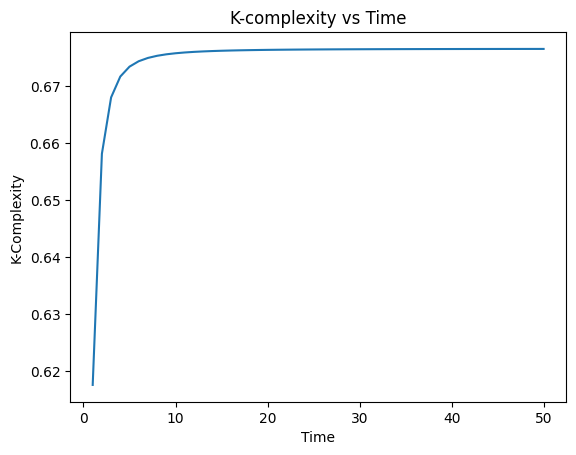

In [2056]:
import matplotlib.pyplot as plt

plt.plot(time,k_complexity)
plt.xlabel("Time")
plt.ylabel("K-Complexity")
plt.title("K-complexity vs Time")

In [ ]:
import numpy as np
from qiskit import quantum_info as qi
n=2
A = np.array([
    [0, -1, 0, 0],
    [1, 0, 0, 0],
    [0, 0, 0, -1],
    [0, 0, 1, 0]
])
cust_gate=qi.Operator(A)


Ucirc = QuantumCircuit(2,0)  
Ucirc.unitary(cust_gate,[0,1],label="Custom gate")
Ucirc.append((qi.random_unitary(2**n)),range(n))
Ucirc.draw("mpl"))